# Impact climatique du secteur électrique français

>Astuces:
>- Pour effacer toutes les sorties: Cell > All Output > Clear
>- Pour exécuter l'ensemble du code: Cell > Run All
>- Pour éxécuter rapidement du code: cliquer sur la cellule puis Maj + Entrée

---------

Tout d'abord, chargeons l'ensemble des données RTE disponibles pour les années 2012 à 2019 (inclus). Ces données ont été téléchargées ici:
* [Production et consommation](https://opendata.reseaux-energies.fr/explore/dataset/eco2mix-national-cons-def/information/)
* [Températures moyennes et de référence](https://opendata.reseaux-energies.fr/explore/dataset/pic-journalier-consommation-brute/information/)
* [Capacités installées](https://opendata.reseaux-energies.fr/explore/dataset/parc-prod-par-filiere/information/)

Ces dernières sont représentés par un tableau à 2 dimensions dont les colonnes sont les différentes variables dont nous disposons et chaque ligne un pas demi-horaire.

Les variables de consommation, de production et de capacités sont en MW et les températures en °C. Le champs 'date' contient la date du jour et le champ 'datetime', le début du slot horaire UTC.

In [25]:
source('./utils.r')
source('./graphs.r')
data = get_country_data('france') # get data from .csv
print(names(data))

 [1] "date"                   "datetime"               "conso"                 
 [4] "oil"                    "coal"                   "gas"                   
 [7] "nuclear"                "wind"                   "solar"                 
[10] "hydro"                  "hydro_pumped_storage"   "bioenergies"           
[13] "physical_flow"          "oil_turbine"            "oil_cogen"             
[16] "oil_others"             "gas_turbine"            "gas_cogen"             
[19] "gas_ccg"                "gas_others"             "hydro_run_of_river"    
[22] "hydro_lake"             "hydro_pumped_discharge" "waste"                 
[25] "biomass"                "biogas"                 "year"                  
[28] "solar_capacities"       "wind_capacities"        "day_peak"              
[31] "mean_temperature"       "reference_temperature" 


## Production

Tout d’abord, comme pour d’autres secteurs, **les émissions liées à la production d’électricité ne sont pas mesurées directement, elles sont calculés à partir de facteurs d’émissions moyens pour chaque type de production.**

Ces facteurs d’émissions moyens exprimés en kg CO2eq/kWh comptabilisent la quantité de gaz à effet de serre (CO2, CH4, N2O) émis pour la production de 1 kWh, en prenant en compte leur potentiel de réchauffement global sur 100 ans.
![Potentiel de réchauffement global](img/PRG.png)

On distingue 2 types de facteur d’émissions:
1. **direct**: on ne prend en compte que les émissions directement lié à la combustion de combustible lorsqu’il y en a un. C’est ce qu’indique par exemple, l’application @eCO2mixRTE de RTE


2. **en analyse de cycle de vie (ACV)**: c’est à dire l’ensemble des émissions de gaz à effet serre engendrées par:
    - l’extraction, le traitement et la combustion (quand il y a) des matières premières
    - la construction et le démantèlement des infrastructures

Nous utiliserons par la suite les facteurs d'émissions en **analyse de cycle de vie** de la [Base Carbone de l'ADEME](https://www.bilans-ges.ademe.fr/) (`ADEME_GHG_FACTORS`) mais les facteurs d'émissions du [GIEC](https://www.ipcc.ch/site/assets/uploads/2018/02/ipcc_wg3_ar5_annex-iii.pdf) (`IPCC_GHG_FACTORS`) sont aussi disponibles.

Vous pouvez aussi mettre vos propres facteurs d'émissions.

In [26]:
ghg_factors = ADEME_GHG_FACTORS # IPCC_GHG_FACTORS

# ghg_factors = c(0.024, 0.012, 0.011, 0.045, 0.490, 0.230, 0.65, 0.82)
# names(ghg_factors) = c('hydro', 'nuclear', 'wind', 'solar', 'gas', 'bioenergies', 'oil', 'coal')

ghg_factors

hydro     nuclear        wind       solar         gas bioenergies 
      0.006       0.006       0.013       0.055       0.418       0.494 
        oil        coal 
      0.730       1.060

La fonction `add_co2_kg` (déclaré dans [utils.r](../edit/utils.r) va calculer pour chaque pas demi-horaire les émissions de gaz à effet de serre associée à la **production** d'électricité en France.

La fonction `mutate` permet de créer un nouvelle colonne dans notre tableau de données.

```R
add_co2_kg = function(data, ghg_factors, energy_factor = MW_TO_KWH) {
    data = data %>%
        mutate(co2_kg = 0) %>%
        add_prod()

    # we sum here emissions for each type of production
    for (prod_type in names(ghg_factors)) {
        data[['co2_kg']] = data[['co2_kg']] +
            data[[prod_type]] * energy_factor * ghg_factors[prod_type]
    }
    
    # then we compute carbon intensity
    data = data %>%
        mutate(co2_kg_kwh = co2_kg / (prod * energy_factor))
    data
}
```

In [27]:
data = add_co2_kg(data, ghg_factors)

Nous avons maintenant les émissions en kg CO2eq pour chaque pas demi-horaire. Affichons maintenant les émissions annuels depuis 2012 du secteur électrique français.

year,co2_mt
<dbl>,<dbl>
2012,38.36617
2013,38.61691
2014,23.72545
2015,27.73999
2016,31.49689
2017,37.45635
2018,28.64885
2019,27.79713


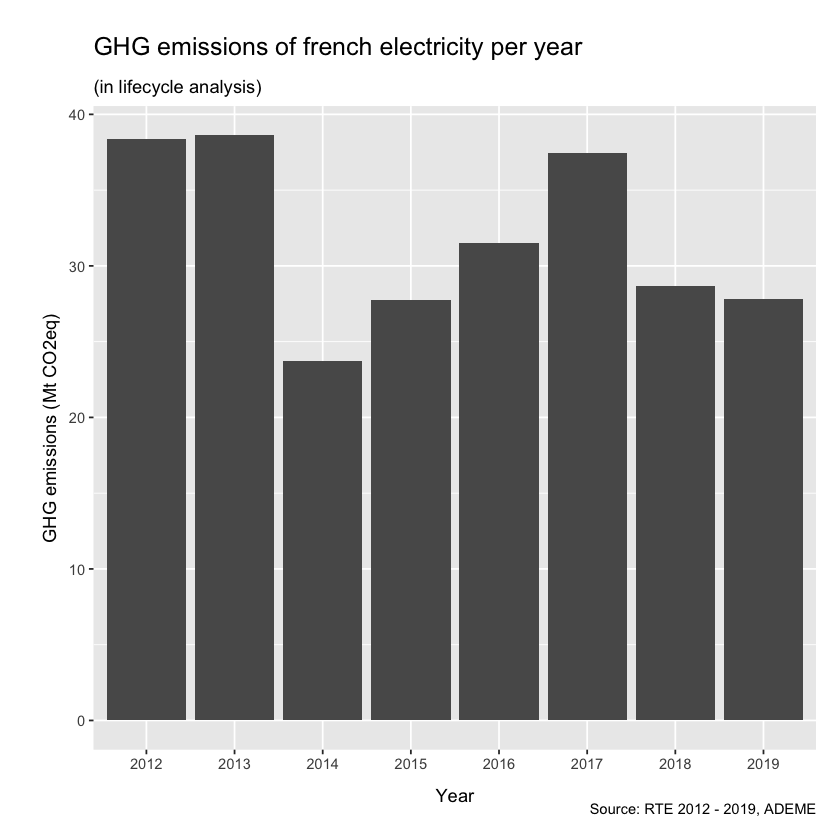

In [28]:
yearly_emissions = data %>%
    group_by(year) %>%
    summarise(
        co2_mt = sum(co2_kg) / 10^9 # conversion from kg to Mt
    )

yearly_emissions

# use of paste to change year to string, it makes this variable discrete
ggplot(yearly_emissions, aes(x = paste(year), y = co2_mt)) + 
    geom_col() +
    labs(
        title = 'GHG emissions of french electricity per year',
        subtitle = '(in lifecycle analysis)',
        x = 'Year',
        y = 'GHG emissions (Mt CO2eq)',
        caption = 'Source: RTE 2012 - 2019, ADEME'
    )

Une autre donnée intéressante est le facteur d'émissions annuel moyen du mix français qu'on peu calculer en divisant l'ensemble des émissions par la production totale.

year,co2_mt,prod_twh,co2_kg_kwh
<dbl>,<dbl>,<dbl>,<dbl>
2012,38.36617,539.3983,0.07112772
2013,38.61691,548.5333,0.07040029
2014,23.72545,538.2703,0.04407720
2015,27.73999,544.6370,0.05093299
2016,31.49689,529.3539,0.05950062
2017,37.45635,527.1957,0.07104827
2018,28.64885,546.6611,0.05240696
2019,27.79713,535.4596,0.05191265


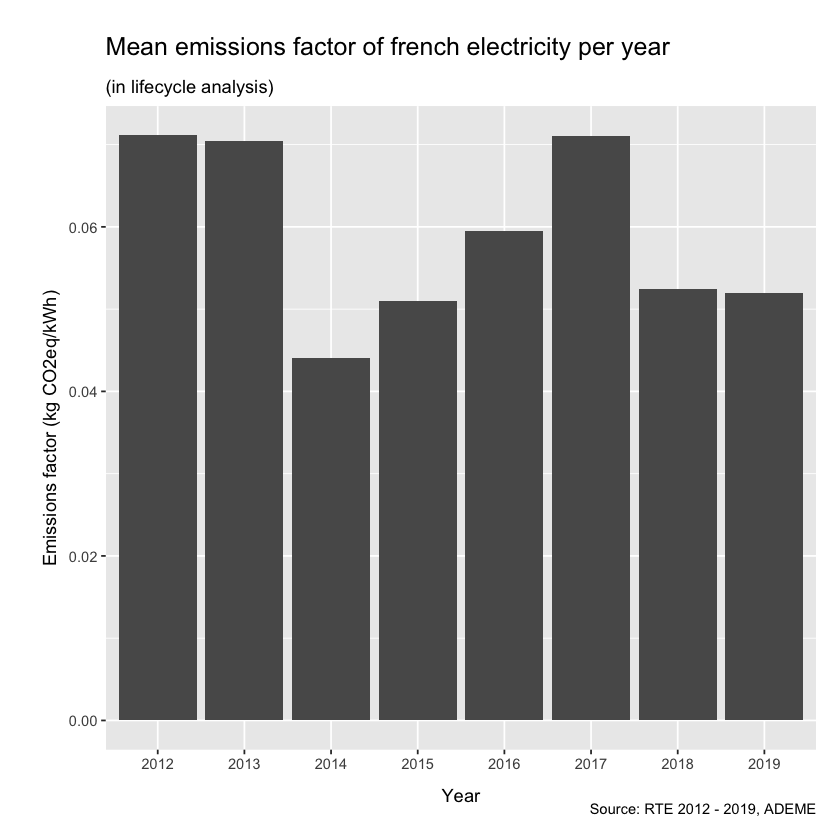

In [29]:
yearly_intensities = data %>%
    add_prod() %>% # compute total of electricity production by slot
    group_by(year) %>%
    summarise(
        co2_mt = sum(co2_kg) / 10^9,
        prod_twh = sum(prod) * MW_TO_KWH / 10^9
    ) %>%
    mutate(co2_kg_kwh = co2_mt / prod_twh)

yearly_intensities

# use of paste to change year to string, it makes this variable discrete
ggplot(yearly_intensities, aes(x = paste(year), y = co2_kg_kwh)) + 
    geom_col() +
    labs(
        title = 'Mean emissions factor of french electricity per year',
        subtitle = '(in lifecycle analysis)',
        x = 'Year',
        y = 'Emissions factor (kg CO2eq/kWh)',
        caption = 'Source: RTE 2012 - 2019, ADEME'
    )

**En grande partie bas-carbone, grâce à la production nucléaire et hydraulique, la France a émis en 2019, 28 millions de tonnes de CO2eq (Mt CO2eq) soit 46 gCO2eq/kWh produit. A titre de comparaison la moyenne européenne est de 420g CO2eq/kWh.**

## Consommation

Maintenant interressons nous à l'intensité carbone de l'électricité qui arrive dans votre prise.

Plusieurs choses sont à prendre en compte en plus de la production:
- les pertes en ligne
- les importations et exportations

Pour les pertes en ligne, nous considérons qu'elles sont constantes et représentent **10% de l'énergie consommée**. Plus de détails, [ici](https://www.connaissancedesenergies.org/electricite-a-combien-s-elevent-les-pertes-en-ligne-en-france-140520).

Concernant les échanges, c’est plus compliqué car à tout instant, la France peut importer de l’électricité d’un pays et en exporter vers un autre (qui eux mêmes peuvent faire de même...).
Par exemple, [ElectricityMap](electricitymap.org) utilise un algorithme pour prendre en compte toutes ces interconnexions mais nous allons simplifier.

Nous allons considérer que les **importations nettes** (ie quand la France importe plus qu’elle n’exporte pendant 1/2h) contiennent **420gCO2eq/kWh (mix moyen européen)** et que **les exportations nettes auront la même intensité que la production.**

La fonction `add_mixin_conso_co2_kg` nous permet de faire ces calculs et d'ajouter plusieurs variables à nos données.

```R
add_mixin_conso_co2_kg = function(data, ghg_factors, import_ghg_factor = IMPORT_GHG_FACTOR) {
    data = data %>%
        add_co2_kg(ghg_factors) %>%
        add_import_export() %>%
        add_prod() %>%
        mutate(
            export_co2_kg = (co2_kg / prod) * export,
            import_co2_kg = import * MW_TO_KWH * import_ghg_factor,
            conso_co2_kg = co2_kg - export_co2_kg + import_co2_kg,

            # hydro_pumped_storage is negative
            conso_co2_kg_kwh = conso_co2_kg / ((conso - hydro_pumped_storage) * MW_TO_KWH),
            export_co2_kg_kwh = export_co2_kg / (export * MW_TO_KWH)
        )
    data
}
```

year,prod_co2_mt,conso_co2_mt,import_co2_mt,export_co2_mt,import_twh,export_twh,conso_co2_kg_kwh,export_co2_kg_kwh
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012,38.36617,36.00582,0.54046923,2.900819,1.2868315,47.42811,0.08140278,0.06116246
2013,38.61691,36.15152,0.32372424,2.789106,0.7707720,49.88708,0.08079616,0.05590838
2014,23.72545,21.08497,0.00574329,2.646226,0.0136745,67.88412,0.05016447,0.03898151
2015,27.73999,24.82440,0.00657657,2.922163,0.0156585,64.60091,0.05771253,0.04523408
2016,31.49689,30.41094,1.03992441,2.125872,2.4760105,44.73620,0.06964524,0.04752018
2017,37.45635,36.32104,1.52752551,2.662833,3.6369655,44.61584,0.08340171,0.05968358
2018,28.64885,26.13832,0.40147758,2.912009,0.9558990,64.68301,0.06046452,0.04501969
2019,27.79713,25.77364,0.67205586,2.695544,1.6001330,60.06671,0.06024996,0.04487584


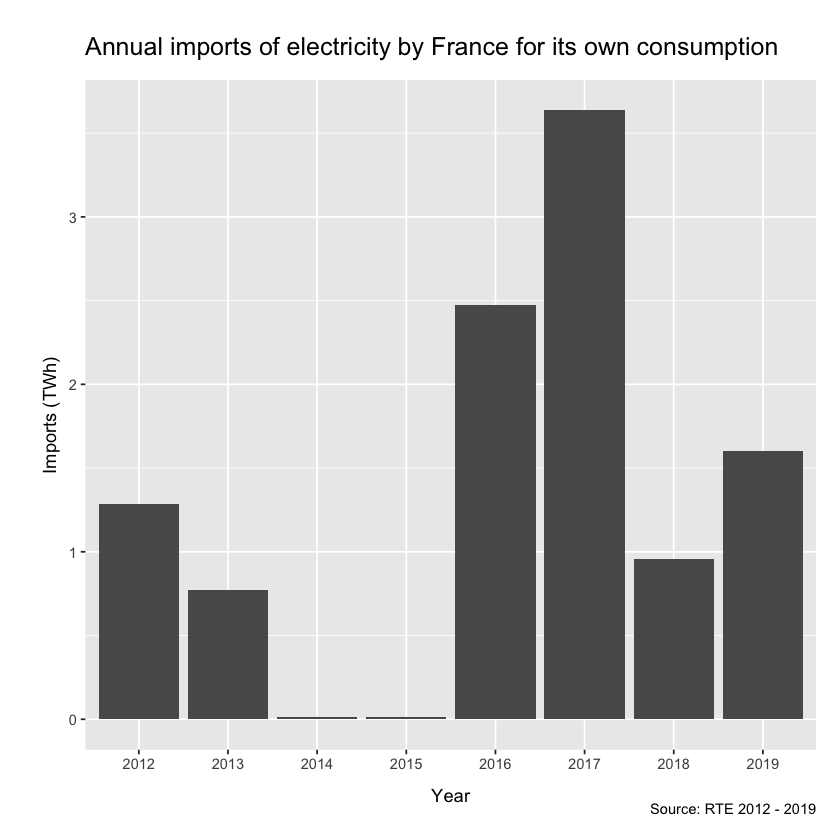

In [30]:
LOSS_RATE = 0.1
yearly_conso_export_intensities = data %>%
    add_mixin_conso_co2_kg(ghg_factors, import_ghg_factor = 0.420) %>%
    group_by(year) %>%
    summarise(
        prod_co2_mt = sum(co2_kg) / 10^9,
        conso_co2_mt = sum(conso_co2_kg) / 10^9,
        import_co2_mt = sum(import_co2_kg) / 10^9,
        export_co2_mt = sum(export_co2_kg) / 10^9,
        conso_twh = sum(conso) * MW_TO_KWH / 10^9,
        import_twh = sum(import) * MW_TO_KWH / 10^9,
        export_twh = sum(export) * MW_TO_KWH / 10^9
    ) %>%
    mutate(conso_co2_kg_kwh = conso_co2_mt / conso_twh * (1 + LOSS_RATE)) %>%
    mutate(export_co2_kg_kwh = export_co2_mt / export_twh) %>%
    select(-conso_twh)

yearly_conso_export_intensities


ggplot(yearly_conso_export_intensities, aes(x = paste(year), y = import_twh)) +
    geom_col() +
    labs(
        title = 'Annual imports of electricity by France for its own consumption',
        x = 'Year',
        y = 'Imports (TWh)',
        caption = 'Source: RTE 2012 - 2019'
    )

Comme nous importons très peu d'électricité pour notre propre consommation, l'électricité qui arrive dans votre prise, a une intensité carbone de l'ordre de **60 à 80g CO2eq/kWh proche de celle de la production**.

En revenche, nous exportons beaucoup d'électricité vers nos voisins. On peut d'ailleurs voir que son intensité est très faible (inférieur à 60gC02eq/kWh): **nous décarbonons l'électricité de nos voisins.** 🙂

-----

> “Et attends, tu as pris une hypothèse assez conservatrice, là ! Quand je regarde Eco2mix, il y a parfois des moments où on aurait pas besoin de faire tourner des centrales à gaz/charbon pour notre conso mais on le fait pour exporter, non ?”

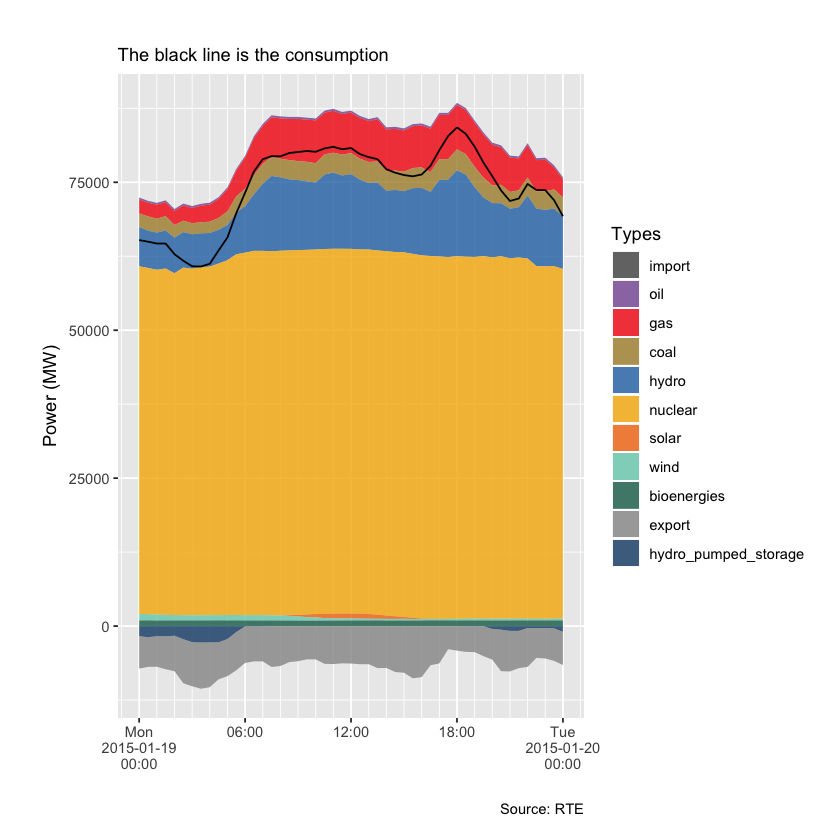

In [37]:
prod_types_order = c('hydro_pumped_storage', 'export', 'bioenergies', 'wind', 'solar', 'nuclear', 'hydro', 'coal', 'gas', 'oil', 'import')
prod_by_types_graph(data, '2015-01-19', '2015-01-20', prod_types_order)

En effet, une partie de la production à base de gaz ne serait, ici, pas nécessaire et ces centrales sont appelés car elle proposent selon le “merit order” un prix plus faible que celui de la dernière centrale appelée dans un autre pays.
![Merit-order](img/merit_order.png)

Pour l'exemple que tu donnes, plusieurs pays frontaliers de la France avaient un prix de l'électricité plus élevé ce qui s'explique par la saturation des interconnexions en export vers ces pays. 
![electricity marker 2015-01-19](img/electricity_market_2015_01_19.png)
![exports marker 2015-01-19](img/exports_2015_01_19.png)

**Mais attention, certaines centrales sont parfois appelées pour stabiliser le réseaux.
D’autre part, les électrons n’ayant pas de couleur, c’est donc un calcul qui n’est pas faux mais qui n’a pas de lien avec la réalité physique. C'est une affectation de la "responsabilité" des émissions.**
De plus, d'un point de vue économique (bénéfices/emplois), la France est aussi bénéficiaire de ces exportations.

Mais essayons ! Considérons comme sur les figures précédentes que le charbon précède le gaz dans le merit order. Hypothèse conservatrice car le facteur d'émission du charbon est bien supérieur à celui du gaz. D'autre part, le gaz est aujourd'hui appelé avant le charbon en France.

Attribuons pour chaque pas demi-horaire, les exportations à tout ou partie de la production:
1. des centrales combinés gaz
2. puis des centrales à charbons
3. puis enfin au mix moyen restant le cas échéant.

**On ne prendra pas en compte les autres moyens fossiles qui tournent souvent en pointe et pour la stabilité réseau, ni les moyens en cogénération tournant en base.
De la même manière, on supposera qu’on importe de l’électricité marginal produite au charbon.**

Pour ce faire, nous utiliserons la fonction `add_marginal_export_conso_co2_kg` (déclaré dans [utils.r](../edit/utils.r). Cette dernière appelle la fonction `add_marginal_export_conso_co2_kg` qui réalise ce que nous venons de décrire.

```R
add_marginal_export_dispatch = function(data) {
    data = data %>%
        mutate(
            remaining_export = export, # all export remained
            
            # affect combined cycle gas production
            export_ccg = if_else(remaining_export - gas_ccg < 0, remaining_export, gas_ccg),
            remaining_export = if_else(remaining_export - gas_ccg < 0, 0, remaining_export - gas_ccg),

            # affect coal production
            export_coal = if_else(remaining_export - coal < 0, remaining_export, coal),
            remaining_export = if_else(remaining_export - coal < 0, 0, remaining_export - coal),

            # compute french use of gas and coal
            conso_coal = coal - export_coal,
            conso_ccg = gas_ccg - export_ccg,
        )
    data
}
```

year,prod_co2_mt,conso_co2_mt,export_co2_mt,import_co2_mt,conso_twh,import_twh,export_twh,conso_co2_kg_kwh,export_co2_kg_kwh
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2014,23.72545,13.24078,10.499166,0.01449497,462.3484,0.0136745,67.88412,0.03150190,0.1546631
2015,27.73999,15.50476,12.251824,0.01659801,473.1528,0.0156585,64.60091,0.03604595,0.1896541
2016,31.49689,24.92922,9.192239,2.62457113,480.3204,2.4760105,44.73620,0.05709135,0.2054765
2017,37.45635,29.61783,11.693695,3.85518343,479.0446,3.6369655,44.61584,0.06800957,0.2620974
2018,28.64885,18.91497,10.747133,1.01325294,475.5210,0.9558990,64.68301,0.04375509,0.1661508
2019,27.79713,21.01447,8.478805,1.69614098,470.5564,1.6001330,60.06671,0.04912463,0.1411565


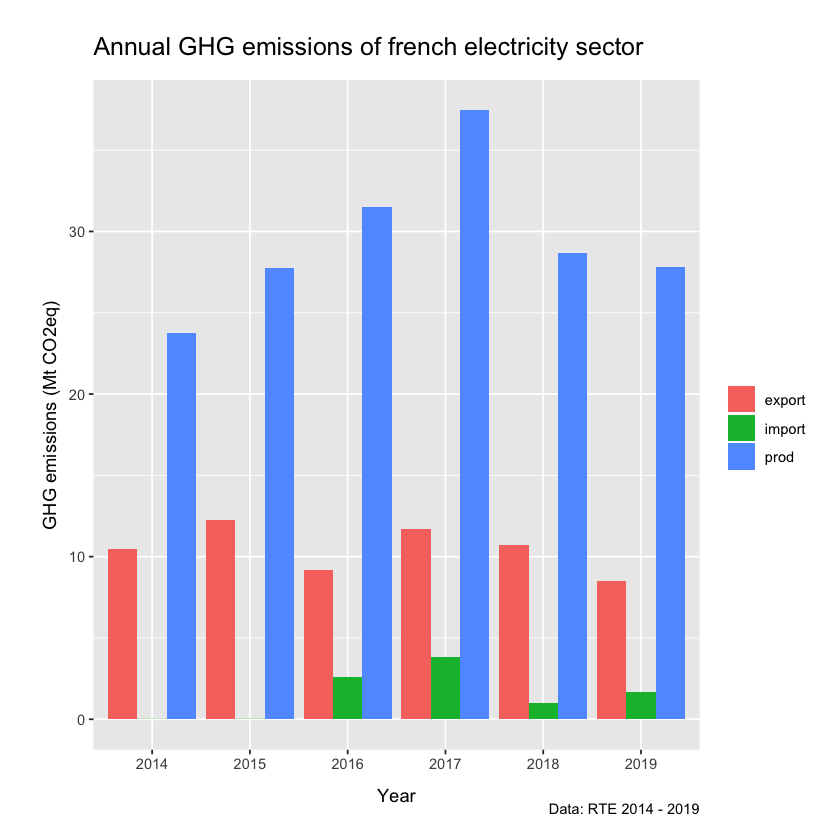

In [32]:
yearly_conso_export_intensities = data %>%
    filter(year > 2013) %>% # ccg production is available since 2014
    add_marginal_export_conso_co2_kg(ghg_factors, import_ghg_factor = ghg_factors['coal']) %>%
    group_by(year) %>%
    summarise(
        prod_co2_mt = sum(co2_kg) / 10^9,
        conso_co2_mt = sum(conso_co2_kg) / 10^9,
        export_co2_mt = sum(export_co2_kg) / 10^9,
        import_co2_mt = sum(import_co2_kg) / 10^9,
        conso_twh = sum(conso) * MW_TO_KWH / 10^9,
        import_twh = sum(import) * MW_TO_KWH / 10^9,
        export_twh = sum(export) * MW_TO_KWH / 10^9
    ) %>%
    mutate(conso_co2_kg_kwh = conso_co2_mt / conso_twh * (1 + LOSS_RATE)) %>%
    mutate(export_co2_kg_kwh = export_co2_mt / export_twh)

yearly_conso_export_intensities

yearly_conso_export_intensities %>%
    rename(
        prod = prod_co2_mt,
        export = export_co2_mt,
        import = import_co2_mt
    ) %>%
    select(year, prod, export, import) %>%
    gather(export, prod, import, key = 'type', value = 'co2_mt') %>%
    ggplot(aes(x = paste(year), y = co2_mt, fill = type)) +
        geom_col(position = position_dodge()) +
        labs(
            title = 'Annual GHG emissions of french electricity sector ',
            x = 'Year',
            y = 'GHG emissions (Mt CO2eq)',
            fill = '',
            caption = 'Data: RTE 2014 - 2019'
        )


Avec ce raisonnement, l'impact de la consommation d'électricité française a considérablement diminué. En effet, on peut voir que **les exportations sont responsables d'une part non négligeable (30% en 2019) de nos émissions de gaz à effet de serre.**

On remarque que même avec ces hypothèses, **le mix exporté est encore faiblement carboné** (150-200g/kWh) par rapport à la moyenne européenne.

## Conclusion

Nous avons vu comment calculé de différentes manières l'impact climatique de la production et de consommation d'électricité en France. Globalement, elle est très peu carboné relativement à la moyenne européenne, en grande partie grâce à la production nucléaire et hydraulique.

**Enfin, le choix des hypothèses peut changer de manière significative les résultats, il est donc important de bien les comprendre et de garder un regard critique sur ces dernières.**

## Docs

N'hésitez pas à consulter les coulisses dans le fichier [utils.r](../edit/utils.r) ou à modifier comme il vous semble cette présentation.

Quelques ressources sur les structures de données et la librairie graphique:
* [Structure de données](https://github.com/rstudio/cheatsheets/blob/master/data-import.pdf)
* [Transformations](https://github.com/rstudio/cheatsheets/blob/master/data-transformation.pdf)
* [Visualisation](https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf)
